# Random circuit sampling data and analysis

In [2]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf
import numpy as np
from math import sqrt
from collections import Counter
mpl.rcParams.update({'errorbar.capsize' : 3})

## Defines functions for linear cross-entropy benchmarking analysis

In [3]:
xv = range(12,36,4)

# Linear cross-entropy benchmark
def XEB(exp_counts, ideal_probs, N):
    shots = sum(exp_counts.values())
    avg = 0
    for bs in list(exp_counts.keys()):
        avg += exp_counts[bs] * ideal_probs[bs]
    avg /= shots
        
    return (2**N) * avg - 1

#Experimentally measured variance of the cross-entropy for a given circuit
def xeb_exp_var(exp_counts, ideal_probs, N):
    shots = sum(exp_counts.values())
    XEB_avg = XEB(exp_counts, ideal_probs, N)
    avg_p = (XEB_avg + 1)/(2**N)
    
    avg_psq = 0
    for bs in list(exp_counts.keys()):
        avg_psq += exp_counts[bs] * (ideal_probs[bs]**2)

    avg_psq /= shots
        
    var_F = (2**(2*N)) * (avg_psq - avg_p**2) / shots
    return var_F

#Converts from process fidelity to average infidelity
def process_fid_to_avg_infid(fid, fid_std_dev):
    return ((4/5)*(1-fid), (4/5)*fid_std_dev)

def tq_gates(N):
    #This encodes the dictionary above with structure: {N: # 2q gates in circuit}
    #tq_gates = {12: 53, 16: 74, 20: 98, 24: 123, 28 147:, 32: 172}
    #This was done to play nicely with scipy.optimize
    return 53*np.heaviside(N - 12,1)+(74-53)*np.heaviside(N-16,1)+(98-74)*np.heaviside(N-20,1)+(123-98)*np.heaviside(N-24,1)+(147-123)*np.heaviside(N-28,1)+(172-147)*np.heaviside(N-32,1)

def theory_fit(N,tq_fid):
    spam_fid = 0.9984
    return  ((tq_fid)**(tq_gates(N))) * (spam_fid)**N

## Analyze data

In [8]:
h2_data = []
h2_data_errs = []

for n in xv:
    with open(f'data/RCS_N{n}_Experiment_10Circuits.json', 'r') as f: 
        save_dict = json.load(f)
    counts_noise = []
    probs_table = []
    for i in range(10):
        probs_table.append(save_dict['bitstring_probs'][str(i)])
        counts_noise.append(Counter(save_dict['exp_results'][str(i)]['c']))
        
        
    xeb = [XEB(counts_noise[i], probs_table[i], n) for i in range(10)]
    xeb_exp_vars = [xeb_exp_var(counts_noise[i], probs_table[i], n) for i in range(10)]

    inv_vars = [1/var for var in xeb_exp_vars]

    xeb = np.average(xeb, weights = inv_vars)
    xeb_variance = 1/sum(inv_vars)

    h2_data.append(xeb)
    h2_data_errs.append(sqrt(xeb_variance))

process_fid, process_fid_variance = cf(theory_fit, list(xv),h2_data, sigma=h2_data_errs,p0=0.998)
#Return average infidelity and 1 sigma error
process_fid_to_avg_infid(process_fid[0], sqrt(process_fid_variance))

theory = [theory_fit(N,process_fid) for N in xv]

[0.942422660370542, 0.7766963372424728, 0.7926537206087036, 0.7245821508270235, 0.7053679775185037, 0.5737546544935302]
[0.04852021422757364, 0.04121764710047375, 0.04444949380046846, 0.04290502080480624, 0.04191331774926624, 0.042715105446884866]


## Plot data

(0.0, 1.0)

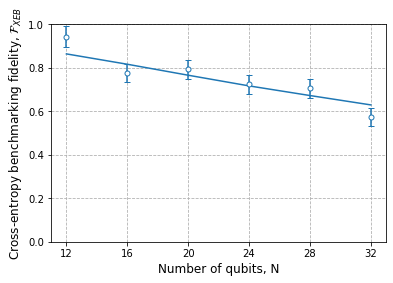

In [11]:
fig, ax = plt.subplots()
fig.set_facecolor('white')

color_list = [plt.get_cmap("tab10").colors[i] for i in range(10)]

ax.errorbar(
            xv,
            h2_data,
            yerr=h2_data_errs,
            fmt="o",
            markersize=5,
            capsize=3,
            ecolor=color_list[0],
            markerfacecolor=[1, 1, 1],
            markeredgecolor=color_list[0],label=None
        )

ax.plot(xv, theory, "-", color=color_list[0])
        
ax.grid(visible=True, axis="both", linestyle="--")
ax.set_xlabel("Number of qubits, N", fontsize=12)
ax.set_ylabel("Cross-entropy benchmarking fidelity, $\mathcal{F}_{{XEB}}$",  fontsize=12)
plt.xticks(xv)
plt.ylim([0.0, 1.0])

<div align="center"> &copy; 2023 by Quantinuum. All Rights Reserved. </div>